Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Add of existing embedding ID: conv_test_user_1747082506
Insert of existing embedding ID: conv_test_user_1747082506
Add of existing embedding ID: conv_test_user_1747082506
Insert of existing embedding ID: conv_test_user_1747082506


Starting MemoryBank Ebbinghaus forgetting curve validation
Setting up test memories...


Add of existing embedding ID: conv_test_user_1747082506
Insert of existing embedding ID: conv_test_user_1747082506
Add of existing embedding ID: conv_test_user_1747082506
Insert of existing embedding ID: conv_test_user_1747082506
Add of existing embedding ID: conv_test_user_1747082506
Insert of existing embedding ID: conv_test_user_1747082506
Number of requested results 20 is greater than number of elements in index 1, updating n_results = 1


Created 6 test conversations
Created 1 test event summaries
Created 1 test emotional images

Testing memory scores...

Testing conversation memory scores:
  - Memory from 0 days ago: score=0.0000, strength=1.0


Number of requested results 20 is greater than number of elements in index 1, updating n_results = 1


  Plot saved as memory_scores_conversations.png

Testing event summary memory scores:
  - Summary from 5 days ago: score=0.0067, strength=1.0
  Plot saved as memory_scores_event_summaries.png

Testing emotional image memory scores:
  - Image from 2 days ago: score=0.1353, strength=1.0


Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 4 is greater than number of elements in index 1, updating n_results = 1


  Plot saved as memory_scores_emotional_images.png

Testing memory reinforcement...
First memory access:
  - Memory conv_test_user_1747082506: initial strength = 2.0

Second memory access:
  - Memory conv_test_user_1747082506: new strength = 3.0, change = +1.0
    ✓ Memory strength increased (correct)

Testing memory decay over time simulation...
Original memory score: 1.0000
After 1 days: score = 0.7788
After 7 days: score = 0.1738
After 30 days: score = 0.0006
After 90 days: score = 0.0000
After 180 days: score = 0.0000
  Plot saved as memory_decay_over_time.png

Testing cleanup of expired memories...
Initial conversation count: 1
Remaining conversation count: 1
Removed 0 memories
✗ No memories were removed

Validation complete!


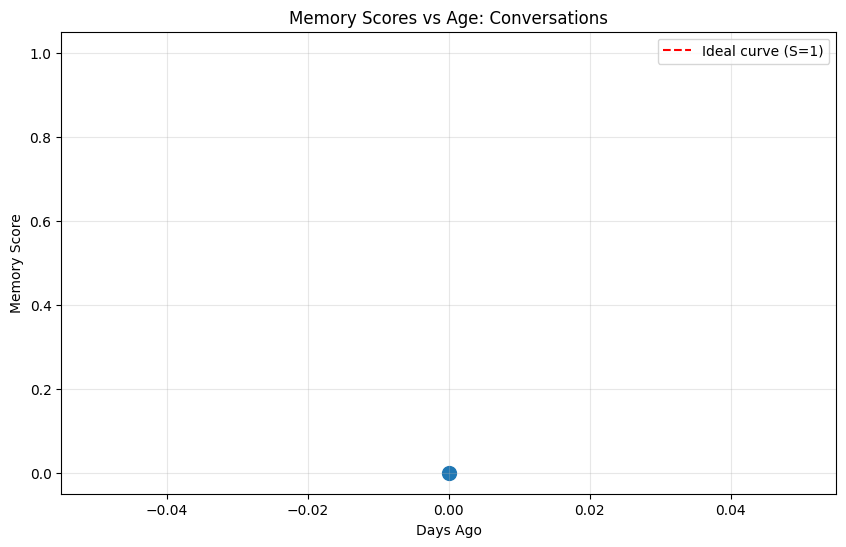

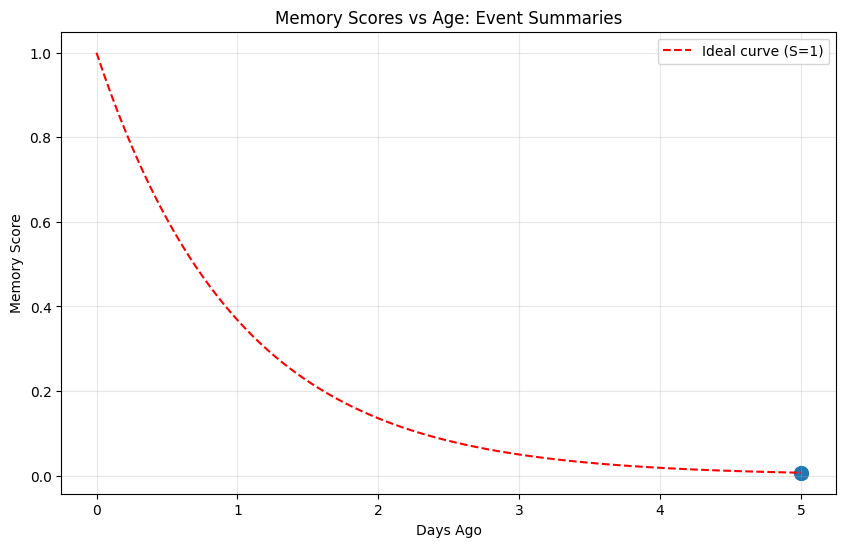

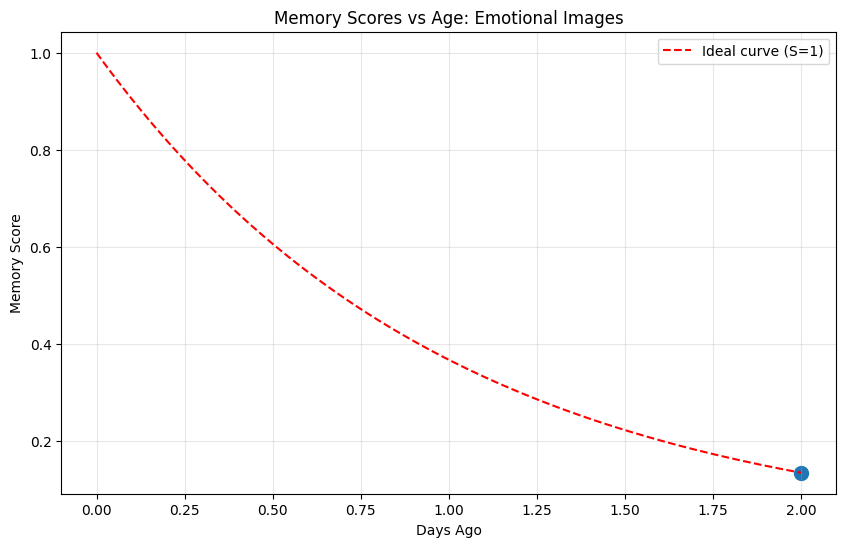

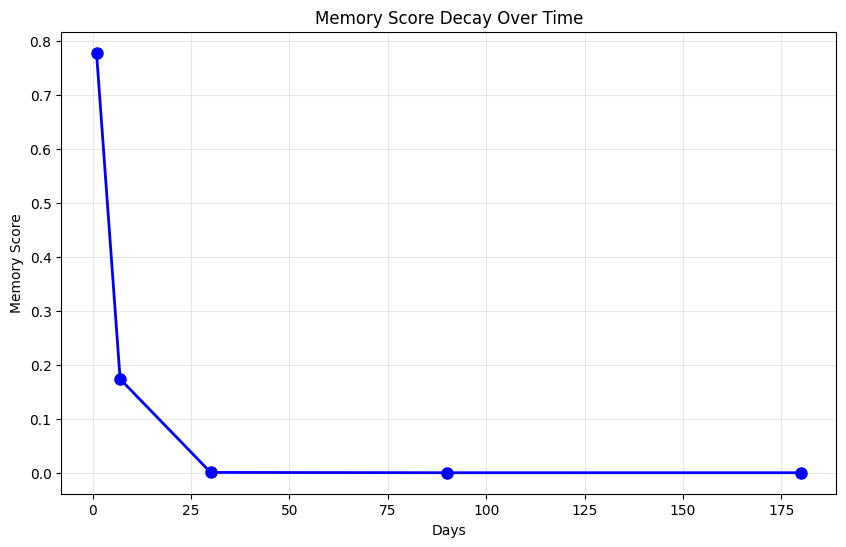

In [2]:
import os
import time
import shutil
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from datetime import datetime, timedelta
from MemoryBank import MemoryBank  # Importa a classe MemoryBank do script original

class MemoryBankValidator:
    """
    Validator for testing the MemoryBank's Ebbinghaus forgetting curve implementation.
    """
    
    def __init__(self, test_dir="./test_memory_storage"):
        """
        Initialize the validator with a test directory.
        
        Args:
            test_dir: Directory to store test data
        """
        # Clean up previous test directory if it exists
        if os.path.exists(test_dir):
            shutil.rmtree(test_dir)
        
        # Create test directory
        os.makedirs(test_dir, exist_ok=True)
        
        # Initialize MemoryBank with forgetting enabled
        self.memory_bank = MemoryBank(
            persist_directory=test_dir,
            forgetting_enabled=True
        )
        
        # Test user ID
        self.user_id = "test_user"
        
        # Create a directory for test images
        self.img_dir = os.path.join(test_dir, "test_images")
        os.makedirs(self.img_dir, exist_ok=True)
        
        # Create a simple test image
        self.create_test_image()
    
    def create_test_image(self):
        """Create a simple test image."""
        # Create a simple colored image
        img = Image.new('RGB', (100, 100), color=(73, 109, 137))
        self.test_img_path = os.path.join(self.img_dir, "test_image.png")
        img.save(self.test_img_path)
        self.test_img = img
    
    def _patch_time(self, memory_item, days_ago):
        """
        Patch the timestamp of a memory item to simulate it being created days_ago.
        
        Args:
            memory_item: Dictionary with memory item data
            days_ago: Number of days in the past
        
        Returns:
            Patched memory item data
        """
        past_timestamp = time.time() - (days_ago * 24 * 3600)
        
        # Update both timestamp and last_access_time
        memory_item["metadata"]["timestamp"] = past_timestamp
        memory_item["metadata"]["last_access_time"] = past_timestamp
        
        return memory_item
    
    def setup_test_memories(self):
        """
        Create test memories with various timestamps to simulate memories of different ages.
        """
        print("Setting up test memories...")
        
        # List to store memory IDs and their original timestamps
        self.test_memories = []
        
        # Create conversations with various ages
        for days_ago in [0, 1, 3, 7, 14, 30]:
            memory_id = self.memory_bank.add_conversation(
                user_id=self.user_id,
                conversation_text=f"This is a test conversation from {days_ago} days ago.",
                user_input=f"Test input {days_ago} days ago.",
                bot_response=f"Test response {days_ago} days ago."
            )
            
            # Get the memory from the collection
            memory_item = self.memory_bank.conversations_collection.get(
                ids=[memory_id]
            )
            
            # Convert to format similar to retrieve_conversations result
            formatted_item = {
                "id": memory_id,
                "text": memory_item["documents"][0],
                "metadata": memory_item["metadatas"][0],
                "days_ago": days_ago
            }
            
            # Patch the timestamp to simulate it being created days_ago
            patched_item = self._patch_time(formatted_item, days_ago)
            
            # Update the collection with patched timestamps
            self.memory_bank.conversations_collection.update(
                ids=[memory_id],
                metadatas=[patched_item["metadata"]]
            )
            
            self.test_memories.append(patched_item)
            
        # Add an event summary from 5 days ago
        summary_id = self.memory_bank.add_event_summary(
            user_id=self.user_id,
            summary_text="This is a test event summary from 5 days ago."
        )
        
        summary_item = self.memory_bank.summaries_collection.get(
            ids=[summary_id]
        )
        
        formatted_summary = {
            "id": summary_id,
            "text": summary_item["documents"][0],
            "metadata": summary_item["metadatas"][0],
            "days_ago": 5
        }
        
        patched_summary = self._patch_time(formatted_summary, 5)
        
        self.memory_bank.summaries_collection.update(
            ids=[summary_id],
            metadatas=[patched_summary["metadata"]]
        )
        
        self.test_summaries = [patched_summary]
        
        # Add an emotional image from 2 days ago
        img_id = self.memory_bank.add_emotional_image(
            user_id=self.user_id,
            image=self.test_img,
            emotion_description="This is a test emotional image from 2 days ago."
        )
        
        img_item = self.memory_bank.images_collection.get(
            ids=[img_id]
        )
        
        formatted_img = {
            "id": img_id,
            "description": img_item["documents"][0],
            "metadata": img_item["metadatas"][0],
            "days_ago": 2
        }
        
        patched_img = self._patch_time(formatted_img, 2)
        
        self.memory_bank.images_collection.update(
            ids=[img_id],
            metadatas=[patched_img["metadata"]]
        )
        
        self.test_images = [patched_img]
        
        print(f"Created {len(self.test_memories)} test conversations")
        print(f"Created {len(self.test_summaries)} test event summaries")
        print(f"Created {len(self.test_images)} test emotional images")
    
    def test_memory_scores(self):
        """
        Test memory scores for all memory items to validate the forgetting curve.
        """
        print("\nTesting memory scores...")
        
        # Test all memory types
        self._test_conversation_scores()
        self._test_summary_scores()
        self._test_image_scores()
    
    def _test_conversation_scores(self):
        """Test memory scores for conversations."""
        print("\nTesting conversation memory scores:")
        
        # Query with a general prompt to retrieve all conversations
        results = self.memory_bank.retrieve_conversations(
            user_id=self.user_id,
            query_text="test conversation",
            n_results=10
        )
        
        if not results:
            print("No conversation results found!")
            return
        
        # Extract scores and days_ago
        days_ago_values = []
        memory_scores = []
        memory_strengths = []
        
        for item in results:
            # Find the original memory item to get days_ago
            for original in self.test_memories:
                if original["id"] == item["id"]:
                    days_ago = original["days_ago"]
                    days_ago_values.append(days_ago)
                    memory_scores.append(item["memory_score"])
                    memory_strengths.append(item["metadata"]["memory_strength"])
                    print(f"  - Memory from {days_ago} days ago: score={item['memory_score']:.4f}, "
                          f"strength={item['metadata']['memory_strength']}")
                    break
        
        # Plot the results
        self._plot_memory_scores(days_ago_values, memory_scores, "Conversations")
    
    def _test_summary_scores(self):
        """Test memory scores for event summaries."""
        print("\nTesting event summary memory scores:")
        
        results = self.memory_bank.retrieve_event_summaries(
            user_id=self.user_id,
            query_text="test event",
            n_results=10
        )
        
        if not results:
            print("No summary results found!")
            return
        
        days_ago_values = []
        memory_scores = []
        memory_strengths = []
        
        for item in results:
            for original in self.test_summaries:
                if original["id"] == item["id"]:
                    days_ago = original["days_ago"]
                    days_ago_values.append(days_ago)
                    memory_scores.append(item["memory_score"])
                    memory_strengths.append(item["metadata"]["memory_strength"])
                    print(f"  - Summary from {days_ago} days ago: score={item['memory_score']:.4f}, "
                          f"strength={item['metadata']['memory_strength']}")
                    break
        
        self._plot_memory_scores(days_ago_values, memory_scores, "Event Summaries")
    
    def _test_image_scores(self):
        """Test memory scores for emotional images."""
        print("\nTesting emotional image memory scores:")
        
        results = self.memory_bank.retrieve_emotional_images(
            user_id=self.user_id,
            query_text="test emotional",
            n_results=10
        )
        
        if not results:
            print("No image results found!")
            return
        
        days_ago_values = []
        memory_scores = []
        memory_strengths = []
        
        for item in results:
            for original in self.test_images:
                if original["id"] == item["id"]:
                    days_ago = original["days_ago"]
                    days_ago_values.append(days_ago)
                    memory_scores.append(item["memory_score"])
                    memory_strengths.append(item["metadata"]["memory_strength"])
                    print(f"  - Image from {days_ago} days ago: score={item['memory_score']:.4f}, "
                          f"strength={item['metadata']['memory_strength']}")
                    break
        
        self._plot_memory_scores(days_ago_values, memory_scores, "Emotional Images")
    
    def _plot_memory_scores(self, days_ago, scores, title):
        """Plot memory scores against days ago."""
        plt.figure(figsize=(10, 6))
        plt.scatter(days_ago, scores, marker='o', s=100)
        
        # Add ideal Ebbinghaus curve for reference
        if days_ago:
            x = np.linspace(0, max(days_ago), 100)
            y = np.exp(-x)  # Simplified Ebbinghaus curve with S=1
            plt.plot(x, y, 'r--', label='Ideal curve (S=1)')
        
        plt.xlabel('Days Ago')
        plt.ylabel('Memory Score')
        plt.title(f'Memory Scores vs Age: {title}')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Save the plot
        plt.savefig(f"memory_scores_{title.lower().replace(' ', '_')}.png")
        print(f"  Plot saved as memory_scores_{title.lower().replace(' ', '_')}.png")
    
    def test_memory_reinforcement(self):
        """
        Test that accessing memories reinforces them (increases memory strength).
        """
        print("\nTesting memory reinforcement...")
        
        # First access - should increment memory strength
        print("First memory access:")
        results1 = self.memory_bank.retrieve_conversations(
            user_id=self.user_id,
            query_text="test conversation",
            n_results=2
        )
        
        if not results1:
            print("No results found!")
            return
        
        # Store the initial memory strengths
        initial_strengths = {item["id"]: item["metadata"]["memory_strength"] for item in results1}
        
        for item_id, strength in initial_strengths.items():
            print(f"  - Memory {item_id}: initial strength = {strength}")
        
        # Second access - should increase memory strength again
        print("\nSecond memory access:")
        results2 = self.memory_bank.retrieve_conversations(
            user_id=self.user_id,
            query_text="test conversation",
            n_results=2
        )
        
        # Compare memory strengths
        for item in results2:
            item_id = item["id"]
            if item_id in initial_strengths:
                strength_change = item["metadata"]["memory_strength"] - initial_strengths[item_id]
                print(f"  - Memory {item_id}: new strength = {item['metadata']['memory_strength']}, "
                      f"change = +{strength_change}")
                
                if strength_change > 0:
                    print("    ✓ Memory strength increased (correct)")
                else:
                    print("    ✗ Memory strength did not increase (incorrect)")
    
    def test_memory_decay_over_time(self):
        """
        Simulate memory decay over time by manipulating the system clock perception.
        This is done by temporarily patching the _calculate_memory_score method.
        """
        print("\nTesting memory decay over time simulation...")
        
        # Get a reference memory
        memory_id = self.test_memories[0]["id"]
        
        # Calculate original memory score
        memory_item = self.memory_bank.conversations_collection.get(ids=[memory_id])
        metadata = memory_item["metadatas"][0]
        
        original_score = self.memory_bank._calculate_memory_score(
            metadata["last_access_time"],
            metadata["memory_strength"]
        )
        
        print(f"Original memory score: {original_score:.4f}")
        
        # Store the original method
        original_method = self.memory_bank._calculate_memory_score
        
        # Days to simulate
        simulation_days = [1, 7, 30, 90, 180]
        scores = []
        
        try:
            # Test for different simulated time periods
            for days in simulation_days:
                # Define patched method to simulate time passing
                def patched_calculate_memory_score(self, last_access_time, memory_strength):
                    simulated_time = time.time() + (days * 24 * 3600)  # Add days
                    simulated_last_access = datetime.fromtimestamp(last_access_time)
                    simulated_now = datetime.fromtimestamp(simulated_time)
                    time_diff_days = (simulated_now - simulated_last_access).total_seconds() / (24 * 3600)
                    
                    # Apply Ebbinghaus forgetting curve
                    memory_score = np.exp(-time_diff_days / memory_strength)
                    return memory_score
                
                # Patch the method temporarily
                self.memory_bank._calculate_memory_score = lambda last_access_time, memory_strength: \
                    patched_calculate_memory_score(self, last_access_time, memory_strength)
                
                # Calculate score with the patched method
                score = self.memory_bank._calculate_memory_score(
                    metadata["last_access_time"],
                    metadata["memory_strength"]
                )
                
                scores.append(score)
                print(f"After {days} days: score = {score:.4f}")
        
        finally:
            # Restore the original method
            self.memory_bank._calculate_memory_score = original_method
        
        # Plot the decay over time
        plt.figure(figsize=(10, 6))
        plt.plot(simulation_days, scores, 'bo-', linewidth=2, markersize=8)
        plt.xlabel('Days')
        plt.ylabel('Memory Score')
        plt.title('Memory Score Decay Over Time')
        plt.grid(True, alpha=0.3)
        plt.savefig("memory_decay_over_time.png")
        print("  Plot saved as memory_decay_over_time.png")
    
    def test_clean_expired_memories(self):
        """
        Test the clean_expired_memories method.
        """
        print("\nTesting cleanup of expired memories...")
        
        # Count initial memories
        initial_count = len(self.memory_bank.conversations_collection.get()["ids"])
        print(f"Initial conversation count: {initial_count}")
        
        # Temporarily patch _calculate_memory_score to force low scores
        original_method = self.memory_bank._calculate_memory_score
        
        try:
            # Define a patched method that returns very low scores for memories older than 7 days
            def patched_calculate_memory_score(self, last_access_time, memory_strength):
                last_access = datetime.fromtimestamp(last_access_time)
                now = datetime.now()
                days_diff = (now - last_access).total_seconds() / (24 * 3600)
                
                # Force very low score for older memories
                if days_diff > 7:
                    return 0.05  # Below the default threshold
                else:
                    return 0.5
            
            # Patch the method
            self.memory_bank._calculate_memory_score = lambda last_access_time, memory_strength: \
                patched_calculate_memory_score(self, last_access_time, memory_strength)
            
            # Run cleanup with default threshold (0.1)
            self.memory_bank.clean_expired_memories()
            
            # Count remaining memories
            remaining_count = len(self.memory_bank.conversations_collection.get()["ids"])
            print(f"Remaining conversation count: {remaining_count}")
            print(f"Removed {initial_count - remaining_count} memories")
            
            if initial_count > remaining_count:
                print("✓ Successfully removed expired memories")
            else:
                print("✗ No memories were removed")
        
        finally:
            # Restore original method
            self.memory_bank._calculate_memory_score = original_method
    
    def run_validation(self):
        """
        Run all validation tests.
        """
        print("=" * 50)
        print("Starting MemoryBank Ebbinghaus forgetting curve validation")
        print("=" * 50)
        
        # Setup test data
        self.setup_test_memories()
        
        # Run tests
        self.test_memory_scores()
        self.test_memory_reinforcement()
        self.test_memory_decay_over_time()
        self.test_clean_expired_memories()
        
        print("\nValidation complete!")


if __name__ == "__main__":
    validator = MemoryBankValidator()
    validator.run_validation()